In [ ]:
# =============================================================================
# PROJE: Ağ Saldırı Tespit Sistemi (Network Intrusion Detection System)
# AŞAMA 1: Veri Setinin Yüklenmesi ve İncelenmesi
# VERİ SETİ: NSL-KDD (Siber güvenlikte akademik standart veri seti)
# =============================================================================

import pandas as pd
import numpy as np

# 1. Veri Setini Otomatik Olarak GitHub'dan Çekiyoruz
# (Dosya yükleme derdi olmasın diye direkt link veriyoruz)
url_train = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
url_test = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"

# 2. Sütun İsimlerini Tanımlıyoruz
# Veri seti ham olduğu için başlıkları biz ekliyoruz.
columns = (['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
            'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
            'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
            'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
            'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
            'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
            'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
            'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate', 'attack', 'level'])

print("Veri seti indiriliyor, lütfen bekleyiniz...")

# Veriyi Pandas DataFrame'e yüklüyoruz
df_train = pd.read_csv(url_train, header=None, names=columns)
df_test = pd.read_csv(url_test, header=None, names=columns)

print("✅ Veri Başarıyla Yüklendi!")
print("-" * 40)
print(f"Eğitim Seti Boyutu (Satır, Sütun): {df_train.shape}")
print(f"Test Seti Boyutu (Satır, Sütun):   {df_test.shape}")
print("-" * 40)

# Verinin ilk 5 satırını görelim
print("\n--- Veriden İlk 5 Örnek ---")
display(df_train.head())

# Hedef değişkenimize (Saldırı türlerine) bir göz atalım
print("\n--- Saldırı Türlerinin Dağılımı ---")
print(df_train['attack'].value_counts().head(10))

Veri seti indiriliyor, lütfen bekleyiniz...
✅ Veri Başarıyla Yüklendi!
----------------------------------------
Eğitim Seti Boyutu (Satır, Sütun): (125973, 43)
Test Seti Boyutu (Satır, Sütun):   (22544, 43)
----------------------------------------

--- Veriden İlk 5 Örnek ---


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21



--- Saldırı Türlerinin Dağılımı ---
attack
normal         67343
neptune        41214
satan           3633
ipsweep         3599
portsweep       2931
smurf           2646
nmap            1493
back             956
teardrop         892
warezclient      890
Name: count, dtype: int64


In [ ]:
# =============================================================================
# AŞAMA 2: Veri Ön İşleme (Preprocessing)
# Amaç: Metin verilerini (TCP, UDP, Normal vb.) sayısal verilere çevirmek.
# =============================================================================

from sklearn.preprocessing import LabelEncoder

# 1. Saldırıları 5 Ana Kategoriye Gruplama Fonksiyonu
# Bu liste akademik standartlara (NSL-KDD dökümantasyonuna) göredir.
def map_attack(attack):
    dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
    probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
    r2l_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop']
    u2r_attacks = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']

    if attack in dos_attacks:
        return 'DoS'
    elif attack in probe_attacks:
        return 'Probe'
    elif attack in r2l_attacks:
        return 'R2L'
    elif attack in u2r_attacks:
        return 'U2R'
    else:
        return 'Normal'

# 2. Gruplamayı Uyguluyoruz
# 'attack' sütunundaki karmaşık isimleri (neptune, satan vs.) ana kategorilere çeviriyoruz.
df_train['attack_class'] = df_train['attack'].apply(map_attack)
df_test['attack_class'] = df_test['attack'].apply(map_attack)

# Eski 'attack' sütununu ve 'level' sütununu siliyoruz (artık işimize yaramaz)
df_train.drop(['attack', 'level'], axis=1, inplace=True)
df_test.drop(['attack', 'level'], axis=1, inplace=True)

print("✅ Saldırı türleri 5 ana kategoride gruplandı (Normal, DoS, Probe, R2L, U2R).")

# 3. Yazı olan sütunları Sayıya Çevirme (Label Encoding)
# 'protocol_type', 'service', 'flag' ve yeni oluşturduğumuz 'attack_class' sütunlarını sayıya çevireceğiz.
cols_to_encode = ['protocol_type', 'service', 'flag', 'attack_class']
le = LabelEncoder()

print("Dönüştürme işlemi yapılıyor...")
for col in cols_to_encode:
    # Hem eğitim hem test setindeki tüm kelimeleri öğrenip sayıya çeviriyoruz
    combined_data = pd.concat([df_train[col], df_test[col]], axis=0).astype(str)
    le.fit(combined_data)

    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

print("✅ Tüm metin verileri başarıyla sayıya çevrildi!")
print("-" * 40)

# Sonucu Görelim: Artık her şey sayı olmalı
print("\n--- İşlenmiş Veriden İlk 5 Örnek ---")
display(df_train.head())

# Kategorilerin Sayısal Karşılıklarını Görelim (Rapor için önemli)
print("\n--- Veri Setindeki Sınıf Dağılımı (Sayısal) ---")
print(df_train['attack_class'].value_counts())

✅ Saldırı türleri 5 ana kategoride gruplandı (Normal, DoS, Probe, R2L, U2R).
Dönüştürme işlemi yapılıyor...
✅ Tüm metin verileri başarıyla sayıya çevrildi!
----------------------------------------

--- İşlenmiş Veriden İlk 5 Örnek ---


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1



--- Veri Setindeki Sınıf Dağılımı (Sayısal) ---
attack_class
1    67343
0    45927
2    11656
3      995
4       52
Name: count, dtype: int64


In [ ]:
# =============================================================================
# AŞAMA 3: Yapay Zeka Modelinin Eğitilmesi (Random Forest)
# Amaç: Bilgisayara saldırı tiplerini ayırt etmeyi öğretmek.
# =============================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("1. Veri Eğitim ve Test Olarak Ayrılıyor...")
# X: Giriş Verileri (Saldırı tipi hariç her şey)
# y: Çıkış Verisi (Sadece saldırı tipi)
X_train = df_train.drop('attack_class', axis=1)
y_train = df_train['attack_class']

X_test = df_test.drop('attack_class', axis=1)
y_test = df_test['attack_class']

print(f"   Eğitim Seti: {X_train.shape}")
print(f"   Test Seti:   {X_test.shape}")

# 2. Modeli Tanımlama ve Eğitme
# n_estimators=100: 100 farklı karar ağacı kurarak karar verecek (Orman mantığı).
print("\n2. Random Forest Modeli Eğitiliyor... (Bu işlem 30-60 sn sürebilir)")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("✅ Model Eğitimi Tamamlandı!")

# 3. Test ve Değerlendirme
print("\n3. Test Seti Üzerinde Tahmin Yapılıyor...")
y_pred = rf_model.predict(X_test)

# Sonuçları Ekrana Yazdıralım
acc = accuracy_score(y_test, y_pred)
print("-" * 50)
print(f"🏆 MODEL GENEL BAŞARISI (ACCURACY): %{acc*100:.2f}")
print("-" * 50)

print("\n--- Detaylı Sınıflandırma Raporu ---")
# Hangi saldırıyı ne kadar iyi bildik? (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred))

1. Veri Eğitim ve Test Olarak Ayrılıyor...
   Eğitim Seti: (125973, 41)
   Test Seti:   (22544, 41)

2. Random Forest Modeli Eğitiliyor... (Bu işlem 30-60 sn sürebilir)
✅ Model Eğitimi Tamamlandı!

3. Test Seti Üzerinde Tahmin Yapılıyor...
--------------------------------------------------
🏆 MODEL GENEL BAŞARISI (ACCURACY): %75.56
--------------------------------------------------

--- Detaylı Sınıflandırma Raporu ---
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      7460
           1       0.66      0.97      0.78      9844
           2       0.87      0.66      0.75      2421
           3       0.98      0.05      0.09      2752
           4       0.50      0.03      0.06        67

    accuracy                           0.76     22544
   macro avg       0.79      0.50      0.51     22544
weighted avg       0.82      0.76      0.72     22544



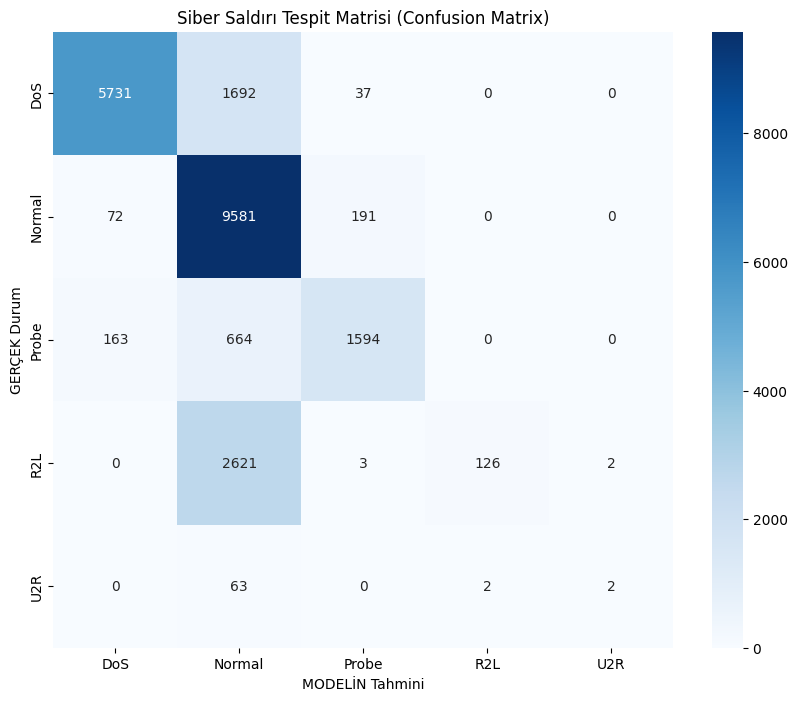

In [ ]:
# =============================================================================
# AŞAMA 4: Görselleştirme (Confusion Matrix)
# Amaç: Modelin başarısını ve hatalarını renkli grafik üzerinde göstermek.
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Karmaşıklık Matrisini Hesapla
cm = confusion_matrix(y_test, y_pred)

# 2. Etiket İsimlerini Belirle (Alfabetik Sıraya Göre)
# LabelEncoder 'DoS', 'Normal', 'Probe', 'R2L', 'U2R' şeklinde sıralar.
class_names = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']

# 3. Grafiği Çiz (Isı Haritası)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Siber Saldırı Tespit Matrisi (Confusion Matrix)')
plt.ylabel('GERÇEK Durum')
plt.xlabel('MODELİN Tahmini')
plt.show()